In [1]:
%matplotlib inline
import os
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))

import torch
from exp.loaddata_utils import ImageNetLoadClass
import exp.utils_visualise as utils_visualise
from torch.autograd import Variable
import matplotlib.pyplot as plt

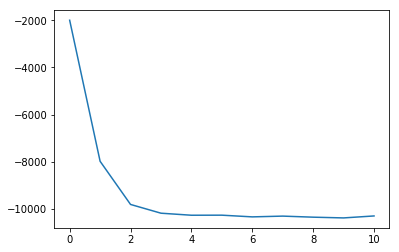

In [2]:
loss = torch.load('../checkpts/1017-vae-mnist_lr_0.001.loss')
plt.plot(range(len(loss)), [loss[i] for i in xrange(len(loss))])
plt.show()

### Test the model

Here I will take some training imagenet images randomly and see how the result goes.
Because my training set is randomly subset of 1/10 of original training sets. I am not sure now the images I take is actually not be seen or seen before. But let's do some sanity check!

Let's corrupt the images! I would try different corruptions.  
Let's try defining some functions here.

In [3]:
def center_corrupt(length=None):
    def tmp(images, length=length):
        clone_images = images.clone()
        _, _, H, W = images.size()
        if length is None:
            length = H / 4
        
        mask = torch.ones(images.size(0), 1, images.size(2), images.size(3))
        
        mask[:, :, (H / 2 - length):(H / 2 + length), (W / 2 - length):(W / 2 + length)] = 0.
        return clone_images * mask, mask
    return tmp

def random_corrupt(prob=0.5):
    def tmp (images):
        clone_images = images.clone()

        mask = torch.bernoulli(torch.FloatTensor(images.size(0), 1, images.size(2), images.size(3)).fill_(prob))
        return clone_images * mask, mask
    return tmp

def corrupt_and_show(images, corrupt_func, generative_model, num_samples=1):
    corrupted_imgs, mask = corrupt_func(images)
    
    arr = []
    for i in xrange(num_samples):
        restored = generative_model.generate_images(images, mask)

        expand_mask = mask.expand_as(restored)

        restored[expand_mask == 1.] = images[expand_mask == 1.]
        arr.append(restored)
    
    fig, ax = plt.subplots(figsize=(20,10))
    utils_visualise.save_figs(ImageNetLoadClass.unnormalize_imagenet_img(corrupted_imgs), '', 
                              nrow=5, visualize=True, ax=ax)
    plt.show()
    plt.close()
    for i in xrange(num_samples):
        fig2, ax2 = plt.subplots(figsize=(20,10))
        utils_visualise.save_figs(ImageNetLoadClass.unnormalize_imagenet_img(arr[i]), '', 
                                  nrow=5, visualize=True, ax = ax2)
        plt.show()
        plt.close()

First, we load some imagenet images.

In [ ]:
from exp.loaddata_utils import load_mnist_loader
train_loader, test_loader = load_mnist_loader(data_dir='../../data', batch_size=10, cuda=False)

images, _ = iter(loader).next()
print images.size()

Processing...


## load the AEGAN model
Note that if sample from x distribution, I would get unreasonable color point.
So just take expectation.

In [8]:
from arch.Inpainting.VAE_InpaintingMnist import VAE_InpaintingMnist

1017-vae-mnist_lr_0.001_epochs_10

from exp.vbd_imagenet.nets.Inpainting.GAN_Inpainting import AE_GAN
generative_model2 = AE_GAN(bvlc_dir='../nets/BVLC/', gan_g_dir='../nets/GAN/', clamp=False)
states = torch.load('../checkpts2/0929-AEGAN-hole_lr_0.0002_epochs_30',
                    map_location=lambda storage, loc: storage)
generative_model2.load_state_dict(states['state_dict'])
generative_model2.eval()

print 'Load generative model'

Load generative model


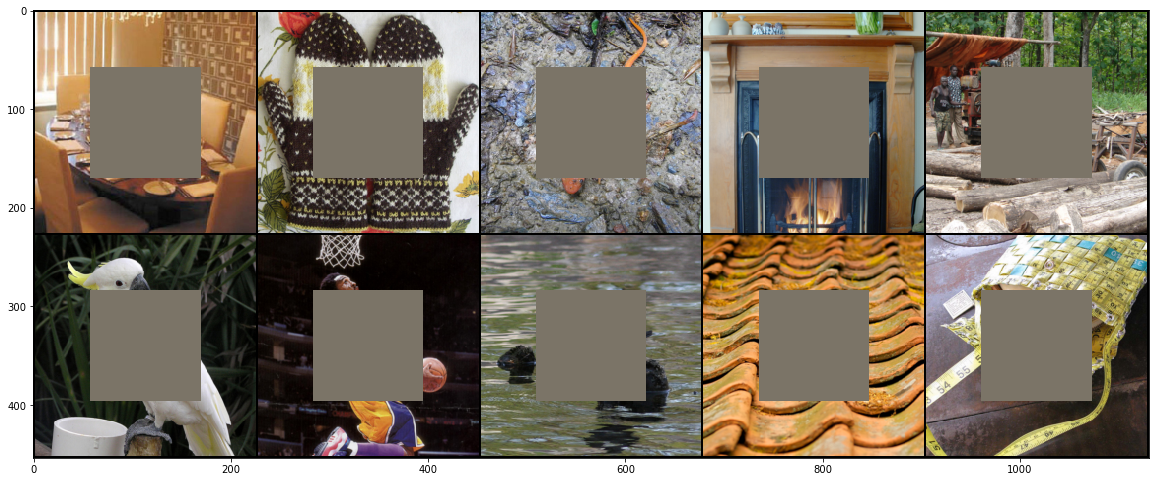

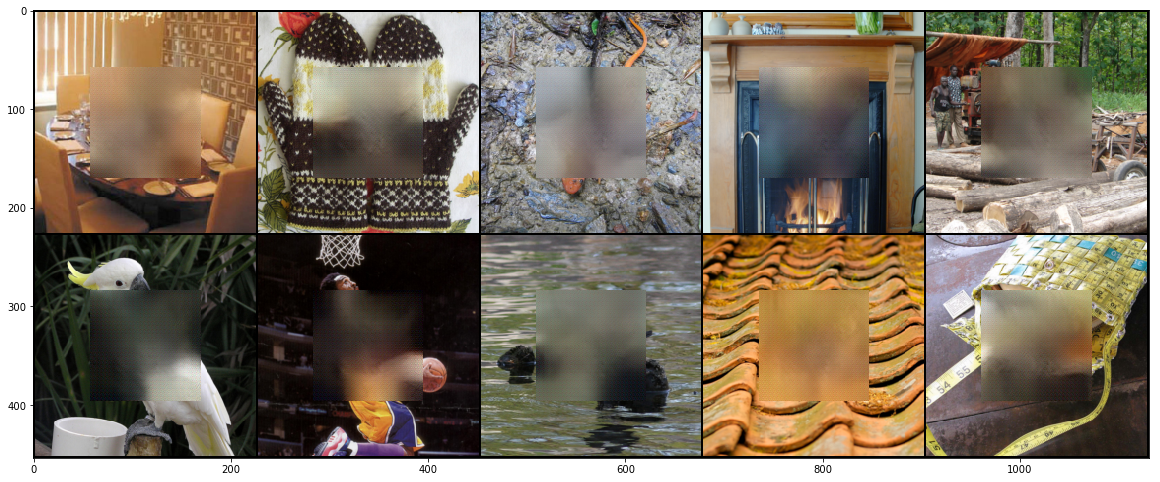

In [9]:
corrupt_and_show(images, corrupt_func=center_corrupt(), generative_model=generative_model2, num_samples=1)

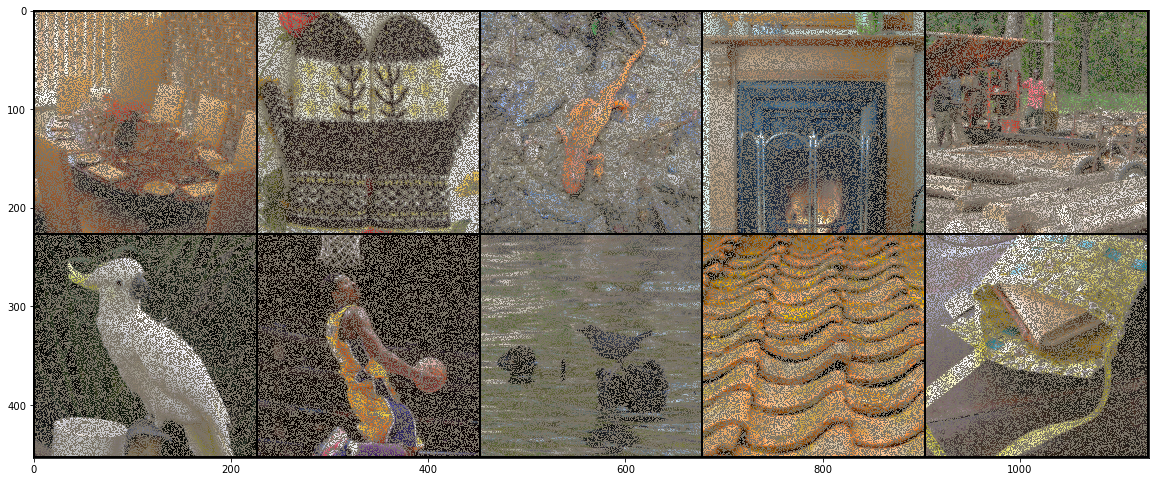

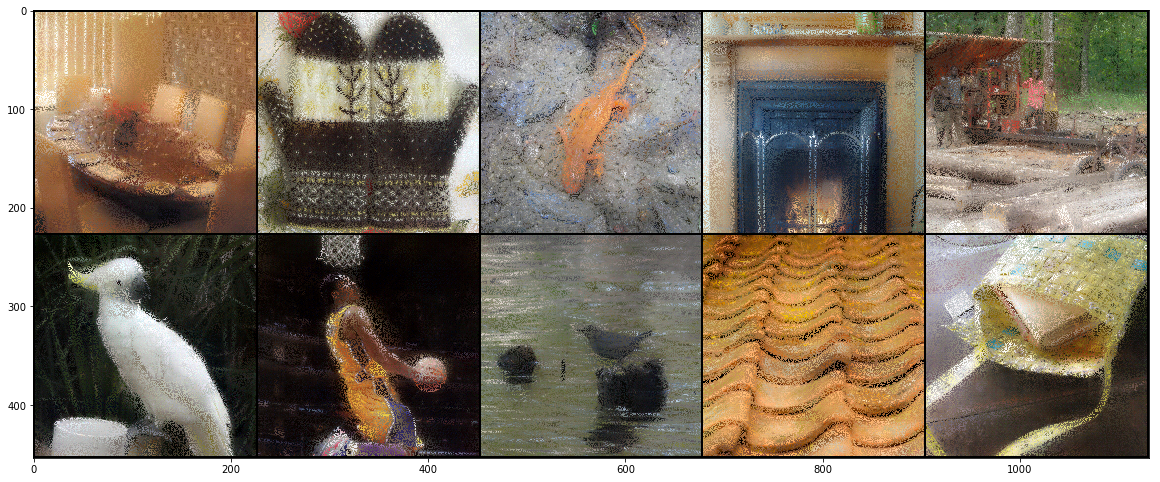

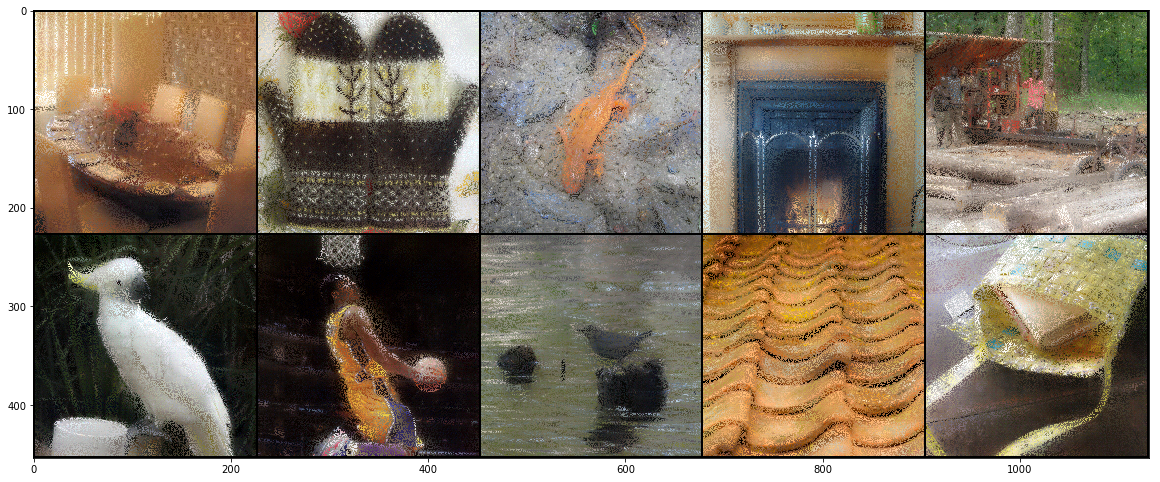

In [10]:
corrupt_and_show(images, corrupt_func=random_corrupt(0.5), generative_model=generative_model2, num_samples=2)